In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
from datetime import datetime
from matplotlib import pyplot as plt
from matplotlib import dates as md

In [2]:
master_url_root = "https://raw.githubusercontent.com/numenta/NAB/master/data/"

df_small_noise_url_suffix = "artificialNoAnomaly/art_daily_small_noise.csv"
df_small_noise_url = master_url_root + df_small_noise_url_suffix
df_small_noise = pd.read_csv(df_small_noise_url)

df_daily_jumpsup_url_suffix = "artificialWithAnomaly/art_daily_jumpsup.csv"
df_daily_jumpsup_url = master_url_root + df_daily_jumpsup_url_suffix
df_daily_jumpsup = pd.read_csv(df_daily_jumpsup_url)

In [3]:
print(df_small_noise.head())

print(df_daily_jumpsup.head())

             timestamp      value
0  2014-04-01 00:00:00  18.324919
1  2014-04-01 00:05:00  21.970327
2  2014-04-01 00:10:00  18.624806
3  2014-04-01 00:15:00  21.953684
4  2014-04-01 00:20:00  21.909120
             timestamp      value
0  2014-04-01 00:00:00  19.761252
1  2014-04-01 00:05:00  20.500833
2  2014-04-01 00:10:00  19.961641
3  2014-04-01 00:15:00  21.490266
4  2014-04-01 00:20:00  20.187739


In [4]:
def plot_dates_values(data):
    dates = data["timestamp"].to_list()
    values = data["value"].to_list()
    dates = [datetime.strptime(x, "%Y-%m-%d %H:%M:%S") for x in dates] # Change from string format to date-time format
    plt.subplots_adjust(bottom=0.2)
    plt.xticks(rotation=25)
    ax = plt.gca()
    xfmt = md.DateFormatter("%Y-%m-%d %H:%M:%S")
    ax.xaxis.set_major_formatter(xfmt)
    plt.plot(dates, values)
    plt.show()

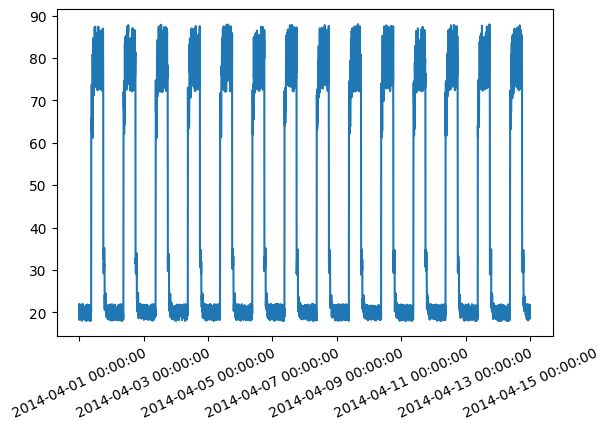

In [5]:
plot_dates_values(df_small_noise)

In [6]:
print(df_small_noise.dtypes)
print(len(df_small_noise["timestamp"]))

timestamp     object
value        float64
dtype: object
4032


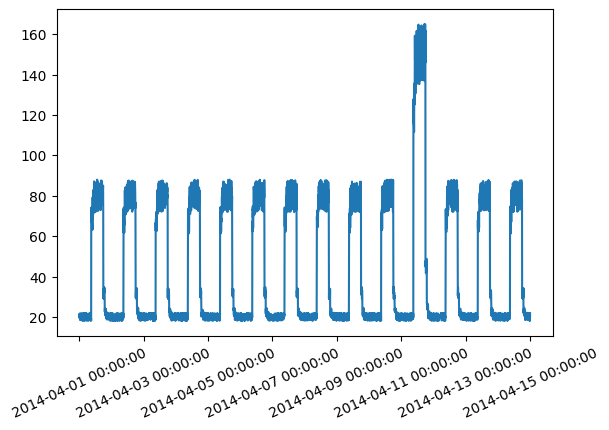

In [7]:
plot_dates_values(df_daily_jumpsup)

In [8]:
def get_value_from_df(df):
    return df.value.to_list() #Extract value from data to a list

def normalize(values):
    mean = np.mean(values)
    values -= mean
    std = np.std(values)
    values /= std
    return values, mean, std


# Get the `value` column from the training dataframe.
training_value = get_value_from_df(df_small_noise) # Training data is the df_small_noise value

# Normalize `value` and save the mean and std we get,
# for normalizing test data.
training_value, training_mean, training_std = normalize(training_value)
len(training_value)

4032

In [9]:
print(training_mean)
print(training_std)

42.43835333580657
28.07364027935401


In [10]:
TIME_STEPS = 288


def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps):
        output.append(values[i : (i + time_steps)])
    # Convert 2D sequences into 3D as we will be feeding this into
    # a convolutional layer.
    return np.expand_dims(output, axis=2) # Reshaping the data from 1D sequence to 2D sequence


x_train = create_sequences(training_value) # training_value shape is 4032x1
# x_train shape is 3744x288x1
print("Training input shape: ", x_train.shape)

Training input shape:  (3744, 288, 1)


### Instead of using only 1 data whose shape is 4032x1, the author re-shaped the 1D sequence raw data into 2D sequence.
In the new training input, there are 3744 tensors which have length of 288 points equivalent to 288 timestep/day 

In [11]:
print(x_train[:2,:3])
print(training_value.shape)

[[[-0.85893509]
  [-0.72908344]
  [-0.84825292]]

 [[-0.72908344]
  [-0.84825292]
  [-0.72967628]]]
(4032,)


In [12]:
device =torch.device("cuda:0" if torch.cuda.is_available() else "Cpu")
print(torch.version.cuda)

11.8


In [ ]:
x_train_tensor = torch.tensor(x_train, dtype=torch.float32) # Convert data from numpy to torch tensors

# Create a dataset and split for validation
dataset = TensorDataset(x_train_tensor, x_train_tensor)  # Autoencoder: input == target

val_size = int(0.1 * len(dataset))
train_size = len(dataset) - val_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# DataLoaders
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [14]:
dataiter = iter(train_loader)
feature, label = next(dataiter)
print(f"Feature batch shape: {feature.shape}")
print(f"Labels batch shape: {label.shape}")

Feature batch shape: torch.Size([128, 288, 1])
Labels batch shape: torch.Size([128, 288, 1])


In [15]:
first_item = dataset[3743]

# Print the shape of each tensor in the first item
print("Shapes of tensors in the first sample:")
for i, tensor in enumerate(first_item):
    print(f"Tensor {i} shape: {tensor.shape}")

Shapes of tensors in the first sample:
Tensor 0 shape: torch.Size([288, 1])
Tensor 1 shape: torch.Size([288, 1])


In [16]:
n_steps = x_train.shape[1] #288 columns
n_features = x_train.shape[2] # = 1 layer

class ConvLSTMAutoencoder(nn.Module):
    def __init__(self, n_steps, n_features):
        super(ConvLSTMAutoencoder, self).__init__() # Inheriting from base class nn.Module, lấy những methods cần thiết chứ không bê tất
        self.n_steps = n_steps
        self.n_features = n_features

        # Conv1D encoder layer
        self.conv1 = nn.Conv1d(
            in_channels=n_features,
            out_channels=32,
            kernel_size=15,
            padding='same',  # Use manual padding below
            dilation=1
        )

        # LSTM encoder
        self.lstm1 = nn.LSTM(
            input_size=32,
            hidden_size=25,
            batch_first=True
        )

        # LSTM decoder
        self.lstm2 = nn.LSTM(
            input_size=25,
            hidden_size=25,
            batch_first=True
        )

        # Conv1D decoder layer
        self.conv2 = nn.Conv1d(
            in_channels=25,
            out_channels=32,
            kernel_size=15,
            padding='same',
            dilation=1
        )

        # TimeDistributed Dense(1)
        self.fc = nn.Linear(32, 1)

    def forward(self, x): #the process of passing input data through the layers of a neural network to obtain an output
        # Input shape: (batch_size, n_steps, n_features)
        # Conv1D in PyTorch expects: (batch_size, channels=n_features, seq_len=n_steps)
        x = x.permute(0, 2, 1)  # (B = 128, C, T), batch size would be set up later, rearrange the input size
        x = self.conv1(x)
        x = x.permute(0, 2, 1)  # rearrange back to (B, T, C) for LSTM

        # LSTM encoder
        _, (h_n, _) = self.lstm1(x)
        h = h_n[0]  # (B, hidden)

        # RepeatVector
        h_repeated = h.unsqueeze(1).repeat(1, self.n_steps, 1)  # (B, T, hidden)

        # LSTM decoder
        x_decoded, _ = self.lstm2(h_repeated)

        # Conv1D decoder
        x_decoded = x_decoded.permute(0, 2, 1)  # (B =128, C=25, T)
        x_decoded = self.conv2(x_decoded)

        # Final TimeDistributed Dense layer
        x_decoded = x_decoded.permute(0, 2, 1)  # (B, T, C=32)
        output = self.fc(x_decoded)  # (B, T, 1)

        return output
model = ConvLSTMAutoencoder(n_steps=n_steps, n_features=n_features)
model.to(device)  # Move model to GPU or CPU

# Optimizer and Loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Print summary-like info
print(model)
if torch.cuda.is_available():
    print(f"Current Device: {torch.cuda.current_device()}")


ConvLSTMAutoencoder(
  (conv1): Conv1d(1, 32, kernel_size=(15,), stride=(1,), padding=same)
  (lstm1): LSTM(32, 25, batch_first=True)
  (lstm2): LSTM(25, 25, batch_first=True)
  (conv2): Conv1d(25, 32, kernel_size=(15,), stride=(1,), padding=same)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)
Current Device: 0


In [17]:
print(x_train_tensor.shape)
print(x_train_tensor[1,1].dtype)

torch.Size([3744, 288, 1])
torch.float32


In [18]:
# Initialize training setup
epochs = 200
patience = 25
best_val_loss = float('inf')
epochs_without_improvement = 0
best_model_state = None
train_losses = []
val_losses = []
for epoch in range(epochs):
    model.train()
    train_loss = 0


    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        output = model(batch_x)
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * batch_x.size(0)

    train_loss /= len(train_loader.dataset)
    


    # Validation phase
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            output = model(batch_x)
            loss = criterion(output, batch_y)
            val_loss += loss.item() * batch_x.size(0)

    val_loss /= len(val_loader.dataset)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f}")

    # Early stopping logic
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict()
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= patience:
            print("Early stopping triggered.")
            break

# Restore best model weights
if best_model_state is not None:
    model.load_state_dict(best_model_state)
if torch.cuda.is_available():
    print(f"Current Device: {torch.cuda.current_device()}")
    print(batch_x.device)

Epoch 1/200 - Train Loss: 0.9966 - Val Loss: 0.9842
Epoch 2/200 - Train Loss: 0.9681 - Val Loss: 0.9601
Epoch 3/200 - Train Loss: 0.9512 - Val Loss: 0.9507
Epoch 4/200 - Train Loss: 0.9363 - Val Loss: 0.9302
Epoch 5/200 - Train Loss: 0.9340 - Val Loss: 0.9432
Epoch 6/200 - Train Loss: 0.9423 - Val Loss: 0.9370
Epoch 7/200 - Train Loss: 0.9301 - Val Loss: 0.9220
Epoch 8/200 - Train Loss: 0.9090 - Val Loss: 0.9001
Epoch 9/200 - Train Loss: 0.8941 - Val Loss: 0.8948
Epoch 10/200 - Train Loss: 0.8834 - Val Loss: 0.8829
Epoch 11/200 - Train Loss: 0.8800 - Val Loss: 0.8813
Epoch 12/200 - Train Loss: 0.8653 - Val Loss: 0.8875
Epoch 13/200 - Train Loss: 0.8771 - Val Loss: 0.8852
Epoch 14/200 - Train Loss: 0.8641 - Val Loss: 0.8829
Epoch 15/200 - Train Loss: 0.8896 - Val Loss: 0.8768
Epoch 16/200 - Train Loss: 0.8809 - Val Loss: 0.8972
Epoch 17/200 - Train Loss: 0.8707 - Val Loss: 0.8665
Epoch 18/200 - Train Loss: 0.8619 - Val Loss: 0.8662
Epoch 19/200 - Train Loss: 0.8638 - Val Loss: 0.8840
Ep

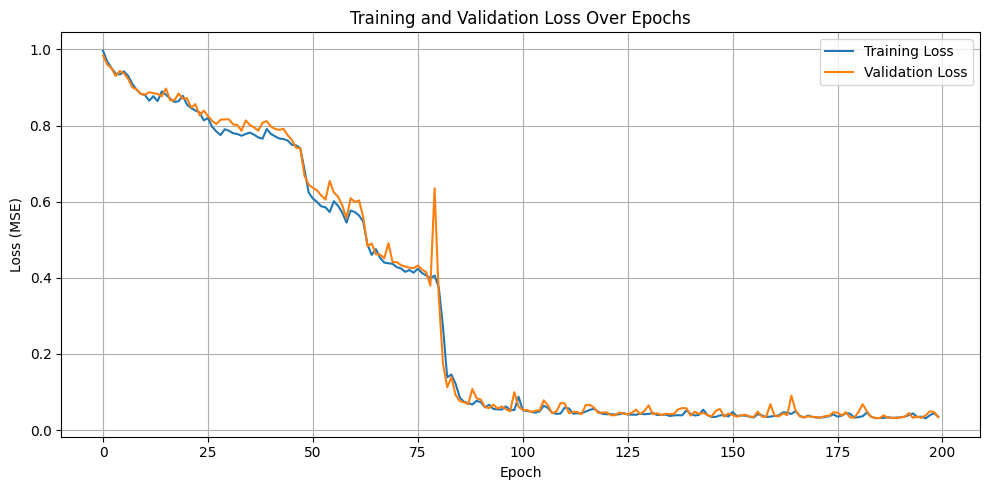

In [19]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.title("Training and Validation Loss Over Epochs")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

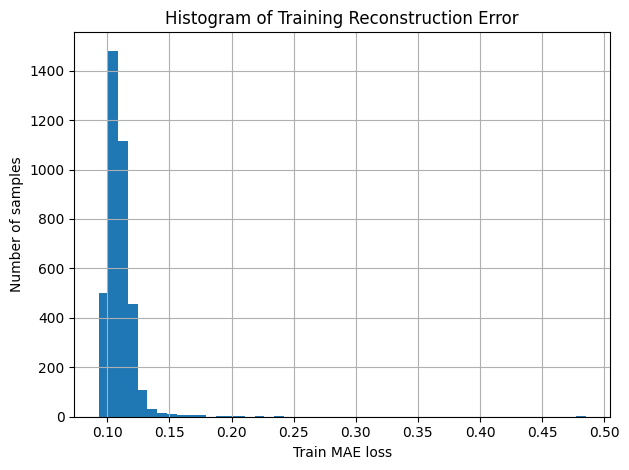

Reconstruction error threshold: 0.4850748


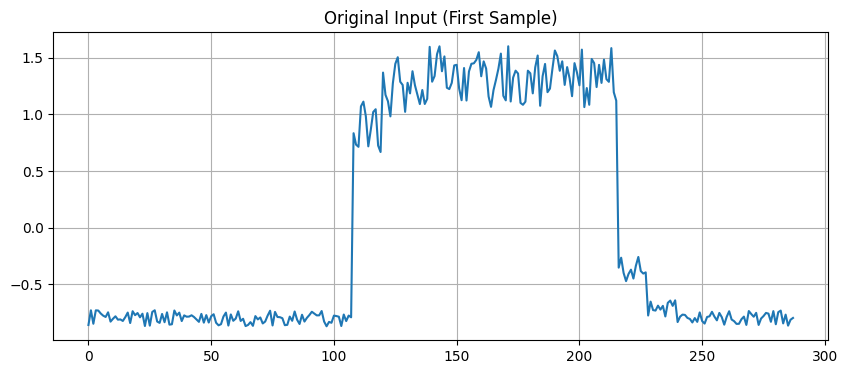

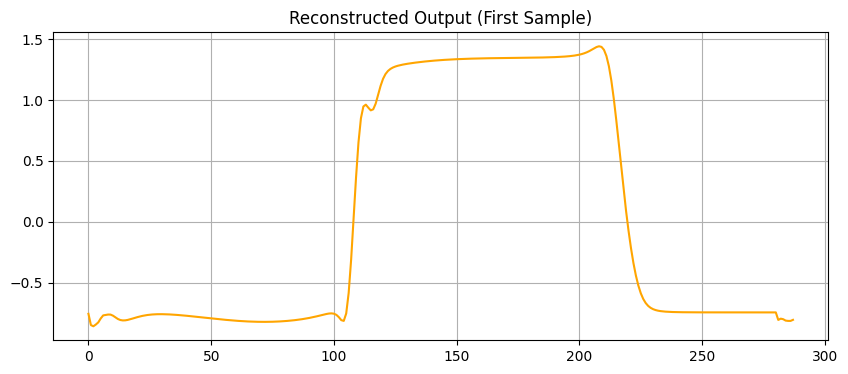

In [20]:
# Make sure model is in eval mode and data is on correct device
model.eval()
x_train_tensor = torch.tensor(x_train, dtype=torch.float32).to(device)

# 1. Predict training data
with torch.no_grad():
    x_train_pred = model(x_train_tensor)

# 2. Move tensors to CPU and convert to NumPy
x_train_pred_np = x_train_pred.cpu().numpy()
x_train_np = x_train_tensor.cpu().numpy()

# 3. Compute MAE per sample (mean over all time steps and features)
# Assume shape is (batch_size, time_steps, features)
train_mae_loss = np.mean(np.abs(x_train_pred_np - x_train_np), axis=(1, 2))  # axis=1 for time only, or (1,2) for full sequence

# 4. Plot histogram of reconstruction loss
plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("Number of samples")
plt.title("Histogram of Training Reconstruction Error")
plt.grid(True)
plt.tight_layout()
plt.show()

# 5. Set anomaly threshold
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold:", threshold)

# 6. Plot first input vs reconstruction
plt.figure(figsize=(10, 4))
plt.plot(x_train_np[0], label="Original")
plt.title("Original Input (First Sample)")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(x_train_pred_np[0], label="Reconstruction", color='orange')
plt.title("Reconstructed Output (First Sample)")
plt.grid(True)
plt.show()

In [21]:
print(x_train_pred_np.shape)

(3744, 288, 1)


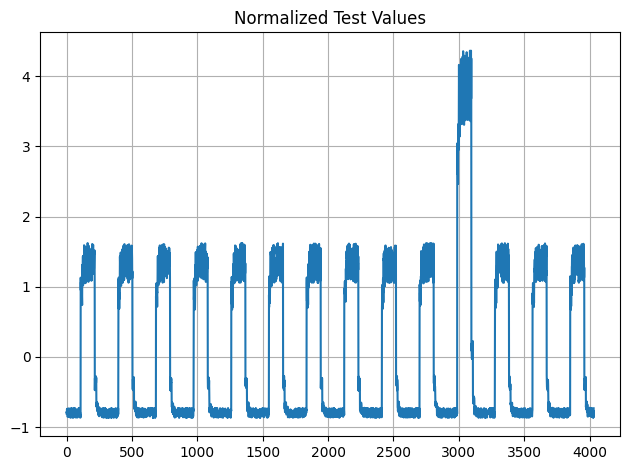

Test input shape: (3744, 288, 1)


In [22]:
def normalize_test(values, mean, std):
    return (values - mean) / std

test_value = get_value_from_df(df_daily_jumpsup)
test_value = normalize_test(test_value, training_mean, training_std)

# Optional: Plot normalized test value
import matplotlib.pyplot as plt
plt.plot(test_value.tolist())
plt.title("Normalized Test Values")
plt.grid(True)
plt.tight_layout()
plt.show()

x_test = create_sequences(test_value)
print("Test input shape:", x_test.shape)  # Should be (num_samples, time_steps, features)

x_test_tensor = torch.tensor(x_test, dtype=torch.float32).to(device)

model.eval()
with torch.no_grad():
    x_test_pred_tensor = model(x_test_tensor)

x_test_pred = x_test_pred_tensor.cpu().numpy()
x_test_np = x_test_tensor.cpu().numpy()

Reconstruction error threshold: 2.0666842


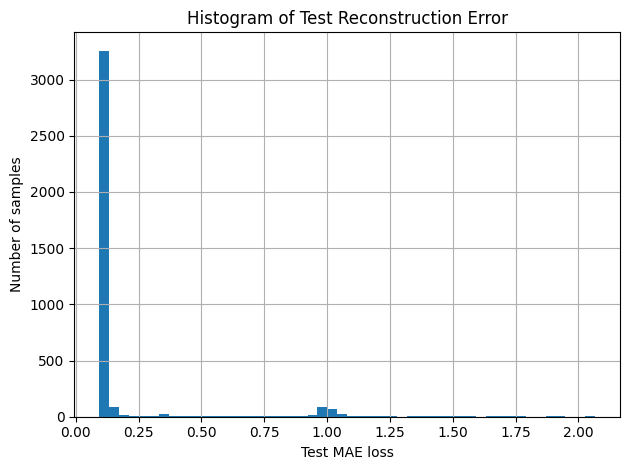

Number of anomaly samples: 315
Indices of anomaly samples: [2738 2739 2740 2741 2742 2743 2744 2745 2746 2747 2748 2749 2750 2751
 2752 2753 2754 2755 2756 2757 2758 2759 2760 2761 2762 2763 2764 2765
 2766 2767 2768 2769 2770 2771 2772 2773 2774 2775 2776 2777 2778 2779
 2780 2781 2782 2783 2784 2785 2786 2787 2788 2789 2790 2791 2792 2793
 2794 2795 2796 2797 2798 2799 2800 2801 2802 2803 2804 2805 2806 2807
 2808 2809 2810 2811 2812 2813 2814 2815 2816 2817 2818 2819 2820 2821
 2822 2823 2824 2825 2826 2827 2828 2829 2830 2831 2832 2833 2834 2835
 2836 2837 2838 2839 2840 2841 2842 2843 2844 2845 2846 2847 2848 2849
 2850 2851 2852 2853 2854 2855 2856 2857 2858 2859 2860 2861 2862 2863
 2864 2865 2866 2867 2868 2869 2870 2871 2872 2873 2874 2875 2876 2877
 2878 2879 2880 2881 2882 2883 2884 2885 2886 2887 2888 2889 2890 2891
 2892 2893 2894 2895 2896 2897 2898 2899 2900 2901 2902 2903 2904 2905
 2906 2907 2908 2909 2910 2911 2912 2913 2914 2915 2916 2917 2918 2919
 2920 2921 2922 29

In [23]:
test_mae_loss = np.mean(np.abs(x_test_pred - x_test_np), axis=(1, 2))  # Shape: (num_samples,)
threshold_test = np.max(test_mae_loss)
print("Reconstruction error threshold:", threshold_test)
plt.hist(test_mae_loss, bins=50)
plt.xlabel("Test MAE loss")
plt.ylabel("Number of samples")
plt.title("Histogram of Test Reconstruction Error")
plt.grid(True)
plt.tight_layout()
plt.show()

# threshold must be defined earlier (e.g., from training data)
anomalies = test_mae_loss > threshold

print("Number of anomaly samples:", np.sum(anomalies))
print("Indices of anomaly samples:", np.where(anomalies)[0])

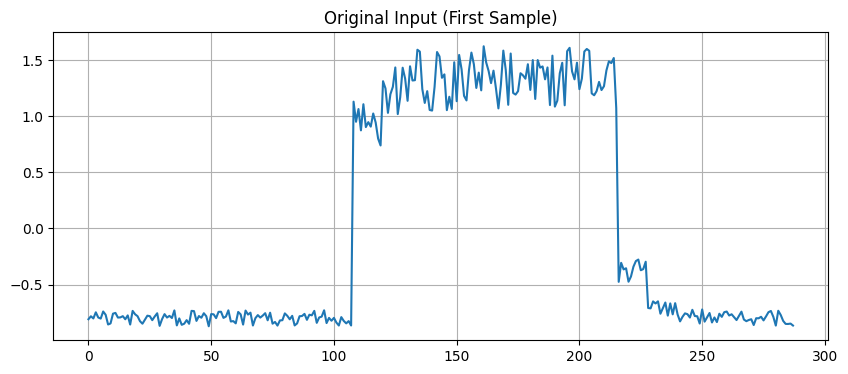

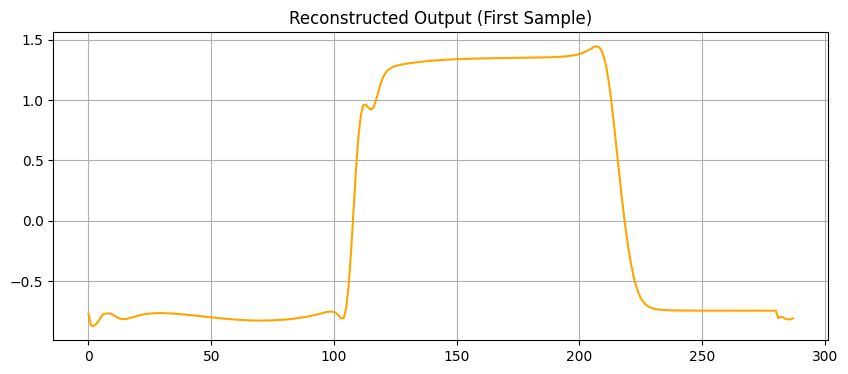

In [24]:
# Plot first input vs reconstruction of test data
plt.figure(figsize=(10, 4))
plt.plot(x_test_np[0], label="Original")
plt.title("Original Input (First Sample)")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(x_test_pred[0], label="Reconstruction", color='orange')
plt.title("Reconstructed Output (First Sample)")
plt.grid(True)
plt.show()

In [25]:
anomalous_data_indices = []

for data_idx in range(TIME_STEPS - 1, len(test_value) - TIME_STEPS + 1):
    time_series = range(data_idx - TIME_STEPS + 1, data_idx)
    if all(anomalies[j] for j in time_series):
        anomalous_data_indices.append(data_idx)

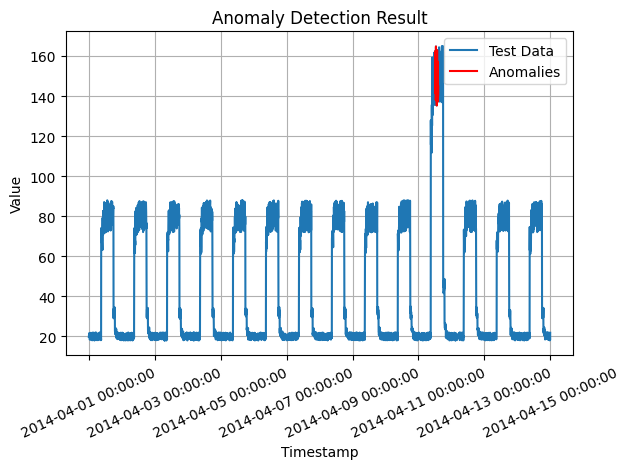

In [26]:
# Get full timestamps and values
df_subset = df_daily_jumpsup.iloc[anomalous_data_indices, :]

# Plot formatting
plt.subplots_adjust(bottom=0.2)
plt.xticks(rotation=25)
ax = plt.gca()
xfmt = md.DateFormatter("%Y-%m-%d %H:%M:%S")
ax.xaxis.set_major_formatter(xfmt)

# Convert date strings to datetime
dates_all = pd.to_datetime(df_daily_jumpsup["timestamp"])
values_all = df_daily_jumpsup["value"]

dates_anomaly = pd.to_datetime(df_subset["timestamp"])
values_anomaly = df_subset["value"]

# Plot full test data
plt.plot(dates_all, values_all, label="Test Data")

# Plot anomalies in red
plt.plot(dates_anomaly, values_anomaly, 'r', label="Anomalies")

plt.legend()
plt.title("Anomaly Detection Result")
plt.xlabel("Timestamp")
plt.ylabel("Value")
plt.grid(True)
plt.tight_layout()
plt.show()

In [27]:
df = pd.DataFrame(df_small_noise)
print(df_small_noise.head())
print(df.dtypes['timestamp'])
print(df.dtypes['value'])

             timestamp      value
0  2014-04-01 00:00:00  18.324919
1  2014-04-01 00:05:00  21.970327
2  2014-04-01 00:10:00  18.624806
3  2014-04-01 00:15:00  21.953684
4  2014-04-01 00:20:00  21.909120
object
float64


In [28]:
# Bỏ tên của class và parameter self ra khỏi method super()
class ConvLSTMAutoencoder2(nn.Module):
    def __init__(self, n_steps, n_features):
        super().__init__() # Inheriting from base class nn.Module, lấy những methods cần thiết chứ không bê tất
        self.n_steps = n_steps
        self.n_features = n_features

        # Conv1D encoder layer
        self.conv1 = nn.Conv1d(
            in_channels=n_features,
            out_channels=32,
            kernel_size=15,
            padding='same',  # Use manual padding below
            dilation=1)

        # LSTM encoder
        self.lstm1 = nn.LSTM(
            input_size=32,
            hidden_size=25,
            batch_first=True)

        # LSTM decoder
        self.lstm2 = nn.LSTM(
            input_size=25,
            hidden_size=25,
            batch_first=True)

        # Conv1D decoder layer
        self.conv2 = nn.Conv1d(
            in_channels=25,
            out_channels=32,
            kernel_size=15,
            padding='same',
            dilation=1)

        # TimeDistributed Dense(1)
        self.fc = nn.Linear(32, 1)

    def forward(self, x): #the process of passing input data through the layers of a neural network to obtain an output
        # Input shape: (batch_size, n_steps, n_features)
        # Conv1D in PyTorch expects: (batch_size, channels=n_features, seq_len=n_steps)
        x = x.permute(0, 2, 1)  # (B = 128, C, T), batch size would be set up later, rearrange the input size
        x = self.conv1(x)
        x = x.permute(0, 2, 1)  # rearrange back to (B, T, C) for LSTM

        # LSTM encoder
        _, (h_n, _) = self.lstm1(x)
        h = h_n[0]  # (B, hidden)

        # RepeatVector
        h_repeated = h.unsqueeze(1).repeat(1, self.n_steps, 1)  # (B, T, hidden)

        # LSTM decoder
        x_decoded, _ = self.lstm2(h_repeated)

        # Conv1D decoder
        x_decoded = x_decoded.permute(0, 2, 1)  # (B =128, C=25, T)
        x_decoded = self.conv2(x_decoded)

        # Final TimeDistributed Dense layer
        x_decoded = x_decoded.permute(0, 2, 1)  # (B, T, C=32)
        output = self.fc(x_decoded)  # (B, T, 1)

        return output
model2 = ConvLSTMAutoencoder(n_steps=n_steps, n_features=n_features)
model2.to(device)  # Move model to GPU or CPU

# Optimizer and Loss
optimizer = torch.optim.Adam(model2.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Print summary-like info
print(model2)
if torch.cuda.is_available():
    print(f"Current Device: {torch.cuda.current_device()}")

ConvLSTMAutoencoder(
  (conv1): Conv1d(1, 32, kernel_size=(15,), stride=(1,), padding=same)
  (lstm1): LSTM(32, 25, batch_first=True)
  (lstm2): LSTM(25, 25, batch_first=True)
  (conv2): Conv1d(25, 32, kernel_size=(15,), stride=(1,), padding=same)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)
Current Device: 0


In [ ]:
# Initialize training setup
epochs = 200
patience = 25
best_val_loss = float('inf')
epochs_without_improvement = 0
best_model_state = None
train_losses = []
val_losses = []
for epoch in range(epochs):
    model2.train()
    train_loss = 0


    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        output = model2(batch_x)
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * batch_x.size(0)

    train_loss /= len(train_loader.dataset)
    


    # Validation phase
    model2.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            output = model2(batch_x)
            loss = criterion(output, batch_y)
            val_loss += loss.item() * batch_x.size(0)

    val_loss /= len(val_loader.dataset)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f}")

    # Early stopping logic
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model2.state_dict()
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= patience:
            print("Early stopping triggered.")
            break

# Restore best model weights
if best_model_state is not None:
    model2.load_state_dict(best_model_state)
if torch.cuda.is_available():
    print(f"Current Device: {torch.cuda.current_device()}")
    print(batch_x.device)

Epoch 1/200 - Train Loss: 1.0022 - Val Loss: 0.9982
Epoch 2/200 - Train Loss: 0.9873 - Val Loss: 0.9664
Epoch 3/200 - Train Loss: 0.9516 - Val Loss: 0.9485
Epoch 4/200 - Train Loss: 0.9232 - Val Loss: 0.9136
Epoch 5/200 - Train Loss: 0.9042 - Val Loss: 0.9144
Epoch 6/200 - Train Loss: 0.8934 - Val Loss: 0.8916
Epoch 7/200 - Train Loss: 0.8840 - Val Loss: 0.8807
Epoch 8/200 - Train Loss: 0.8901 - Val Loss: 0.9108
Epoch 9/200 - Train Loss: 0.8981 - Val Loss: 1.0093
Epoch 10/200 - Train Loss: 0.9368 - Val Loss: 0.9291
Epoch 11/200 - Train Loss: 0.9117 - Val Loss: 0.8984
Epoch 12/200 - Train Loss: 0.8915 - Val Loss: 0.9035
Epoch 13/200 - Train Loss: 0.8873 - Val Loss: 0.8939
Epoch 14/200 - Train Loss: 0.8977 - Val Loss: 0.9182
Epoch 15/200 - Train Loss: 0.8941 - Val Loss: 0.8770
Epoch 16/200 - Train Loss: 0.8770 - Val Loss: 0.8873
Epoch 17/200 - Train Loss: 0.8755 - Val Loss: 0.8723
Epoch 18/200 - Train Loss: 0.8612 - Val Loss: 0.8821
Epoch 19/200 - Train Loss: 0.8848 - Val Loss: 0.8796
Ep

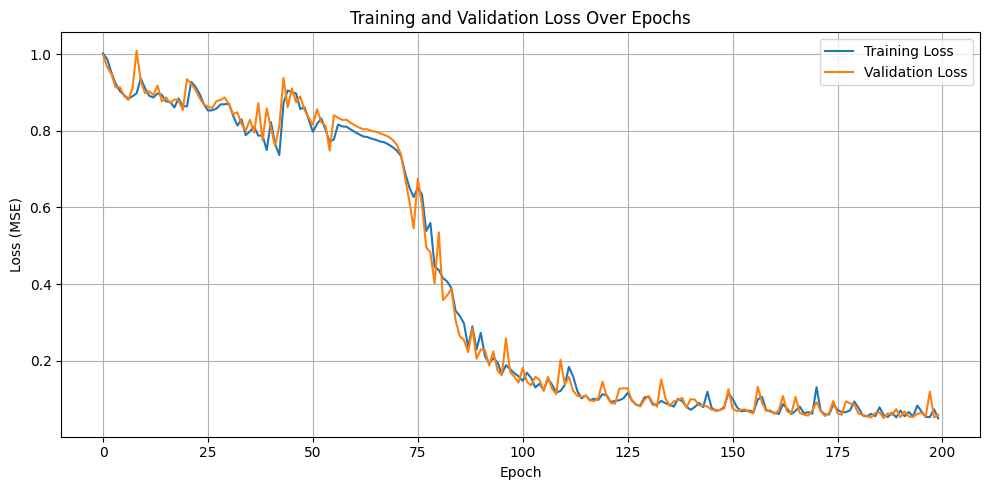

In [30]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.title("Training and Validation Loss Over Epochs")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()